In [1]:
import sys
import os

!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 53.8 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/Romain-MIPI/Reinforcement-Learning-for-De-Novo-Drug-Design.git

Cloning into 'Reinforcement-Learning-for-De-Novo-Drug-Design'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 286 (delta 16), reused 70 (delta 11), pack-reused 200 (from 1)
Receiving objects: 100% (286/286), 91.88 MiB | 22.12 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [3]:
%cd Reinforcement-Learning-for-De-Novo-Drug-Design

/content/Reinforcement-Learning-for-De-Novo-Drug-Design


In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [6]:
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, precision_score
import pandas as pd
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F

In [8]:
from tqdm import tqdm, trange
from rdkit import Chem, DataStructs
from models.rnn_generative import RNNGenerative
from models.generator_data import GeneratorData
from models.utils import canonical_smiles
%matplotlib inline

import seaborn as sns

In [9]:
from rdkit.Chem import QED

gen_data_path = './data/clean_020724_all_with_update.csv'
data = pd.read_csv(gen_data_path)
smiles = data['SMILES'].values

In [10]:
from models.utils import get_tokens
my_tokens, _, _ = get_tokens(smiles)
l_tokens = list(my_tokens) + ['<', '>']

In [11]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',',
                         cols_to_read=[12], keep_header=False, tokens=l_tokens)

In [28]:
def plot_bar(prediction, n_to_generate):
    value, count = np.unique(prediction, return_counts=True)
    print("Percentage predict class 0 (inactive) :", count[np.where(value==0)]/len(prediction))
    print("Percentage predict class 1 (weakly actif) :", count[np.where(value==1)]/len(prediction))
    print("Percentage predict class 2 (strongly actif) :", count[np.where(value==2)]/len(prediction))
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate, f"({len(prediction)}/{n_to_generate})")
    plt.bar(value, count)
    plt.xlabel('Predicted class')
    plt.ylabel('Number of molecules')
    plt.xticks([0, 1, 2], ['class 0', 'class 1', 'class 2'])
    plt.title('Distribution of predicted class for generated molecules')
    plt.show()

In [21]:
def estimate_and_update(generator, predictor, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles)

    plot_bar(prediction, n_to_generate)

    return smiles, prediction

In [14]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [15]:
hidden_size = 500
stack_width = 500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = RNNGenerative(input_size=gen_data.n_characters, hidden_size=hidden_size,
                             output_size=gen_data.n_characters, layer_type=layer_type,
                             n_layers=1, is_bidirectional=False, has_stack=True,
                             stack_width=stack_width, stack_depth=stack_depth,
                             use_cuda=use_cuda,
                             optimizer_instance=optimizer_instance, lr=lr)

In [16]:
model_path = './data/checkpoints/generator/checkpoint_stack_rnn'

In [ ]:
# training generative model

losses = my_generator.fit(gen_data, 50000)
plt.plot(losses)
my_generator.evaluate(gen_data)
my_generator.save_model(model_path)

In [18]:
my_generator.load_model(model_path)

In [19]:
from models.rnn_predictor import RNNPredictor

path_to_params = './data/checkpoints/classification/model_parameters.pkl'
path_to_checkpoint = './data/checkpoints/classification/fold_'

my_predictor = RNNPredictor(path_to_params, path_to_checkpoint, l_tokens)

ストリーミング出力は最後の 5000 行に切り捨てられました。
[14:09:18] SMILES Parse Error: unclosed ring for input: 'CO[C@@H](CN)N[C@H](S(CC)C)[C@H]1C(O)(=O)=CC(O)=C3/C1=C(C(O)=O)=NC1=CC(OC)=C/C3=C(O)C=C(O)C=C4'
[14:09:18] SMILES Parse Error: extra open parentheses for input: 'O[C@H](NC(C(O)=O)C2=C1C=CC=C2O/C1=O'
[14:09:18] SMILES Parse Error: syntax error while parsing: O=B1[C@]@[](](O)(O)=O)C1=C2)=O
[14:09:18] SMILES Parse Error: Failed parsing SMILES 'O=B1[C@]@[](](O)(O)=O)C1=C2)=O' for input: 'O=B1[C@]@[](](O)(O)=O)C1=C2)=O'
[14:09:18] SMILES Parse Error: extra close parentheses while parsing: O=C(/C1=C(NC2=CC=C(C5P(O)C)C(C)C)C=C3)C2=NC4=NC=C3)C(=O)(O
[14:09:18] SMILES Parse Error: Failed parsing SMILES 'O=C(/C1=C(NC2=CC=C(C5P(O)C)C(C)C)C=C3)C2=NC4=NC=C3)C(=O)(O' for input: 'O=C(/C1=C(NC2=CC=C(C5P(O)C)C(C)C)C=C3)C2=NC4=NC=C3)C(=O)(O'
[14:09:18] SMILES Parse Error: unclosed ring for input: 'SCC1=CC(C(O)=O)=CC(C2=CC=CC=C2)OC2=C1NN=C(C3)C(=O)O'
[14:09:18] SMILES Parse Error: unclosed ring for input: 'S=C1N'
[14:

Percentage predict class 0 (inactive) : [0.79789272]
Percentage predict class 1 (weakly actif) : [0.15421456]
Percentage predict class 2 (strongly actif) : [0.04789272]
Proportion of valid SMILES: 0.1044 (1044/10000)


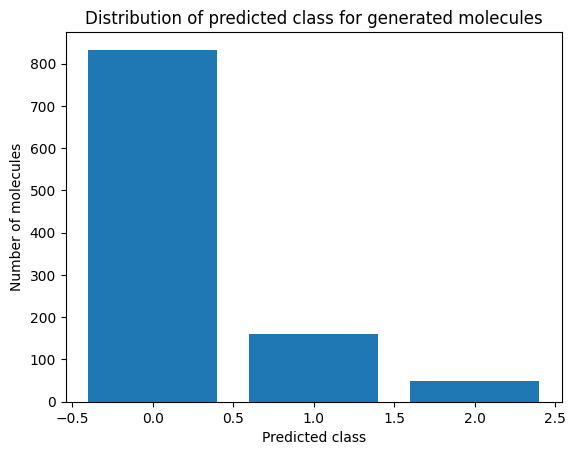

In [27]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=10000)

In [30]:
my_generator_2 = RNNGenerative(input_size=gen_data.n_characters,
                              hidden_size=hidden_size,
                              output_size=gen_data.n_characters,
                              layer_type=layer_type,
                              n_layers=1, is_bidirectional=False, has_stack=True,
                              stack_width=stack_width, stack_depth=stack_depth,
                              use_cuda=use_cuda,
                              optimizer_instance=optimizer_instance, lr=lr)

my_generator_2.load_model(model_path)

In [31]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [32]:
def get_reward_activity(smile, predictor, invalid_reward=0.0):
    _, prediction, invalid_smiles = predictor.predict([smile])
    if len(invalid_smiles) == 1:
        return invalid_reward
    if (prediction[0] == 2):
        return 11.0
    elif (prediction[0] == 1):
        return 6.0
    else:
        return 1.0

Policy gradient...:  93%|█████████▎| 14/15 [00:11<00:00,  1.30it/s][14:48:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC=CC=C1C2=CC=CC=C4'
[14:48:00] SMILES Parse Error: syntax error while parsing: %C1=CC=CC=C1
[14:48:00] SMILES Parse Error: Failed parsing SMILES '%C1=CC=CC=C1' for input: '%C1=CC=CC=C1'
[14:48:00] SMILES Parse Error: unclosed ring for input: 'O=C(CC(C)=S)C=C1'
[14:48:00] SMILES Parse Error: extra open parentheses for input: 'SC1=CC=CC(S1'
Policy gradient...: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


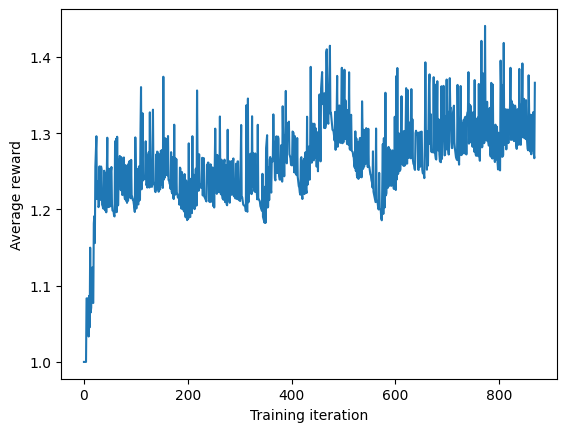

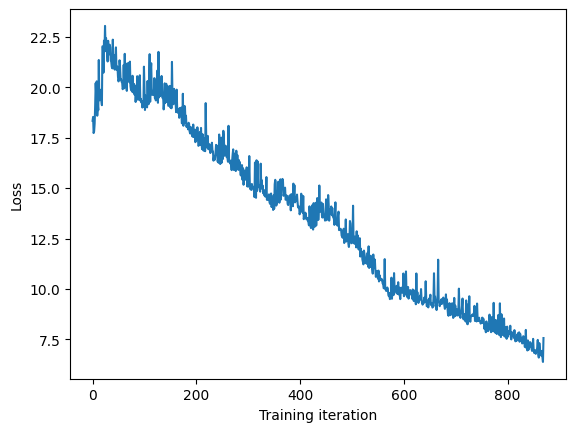

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 47.24it/s]
[14:48:05] SMILES Parse Error: unclosed ring for input: 'OC(C=C1)=O'
[14:48:05] SMILES Parse Error: unclosed ring for input: 'OCC1=CC=CC(C(OC)=O)NC1=CC=CC=C1'
[14:48:05] SMILES Parse Error: unclosed ring for input: 'SCC1=CC=CC(C2=CC=CC=C3)=C1'
[14:48:05] SMILES Parse Error: extra open parentheses for input: 'OC(C1=CC=CC=C1'
[14:48:05] SMILES Parse Error: extra open parentheses for input: 'OC1=CC=C(C4=CC=CC=C1'
[14:48:05] SMILES Parse Error: syntax error while parsing: HCC1=CC=CC=C1
[14:48:05] SMILES Parse Error: Failed parsing SMILES 'HCC1=CC=CC=C1' for input: 'HCC1=CC=CC=C1'
[14:48:05] SMILES Parse Error: extra close parentheses while parsing: [C@H](C1=CC=CC=C1)=O)CC(O)=O
[14:48:05] SMILES Parse Error: Failed parsing SMILES '[C@H](C1=CC=CC=C1)=O)CC(O)=O' for input: '[C@H](C1=CC=CC=C1)=O)CC(O)=O'
[14:48:05] SMILES Parse Error: extra close parentheses while parsing: CCC)=C1
[14:48:05] SMILES Parse Error: Failed p

Percentage predict class 0 (inactive) : [0.75384615]
Percentage predict class 1 (weakly actif) : [0.2]
Percentage predict class 2 (strongly actif) : [0.04615385]
Proportion of valid SMILES: 0.325 (65/200)


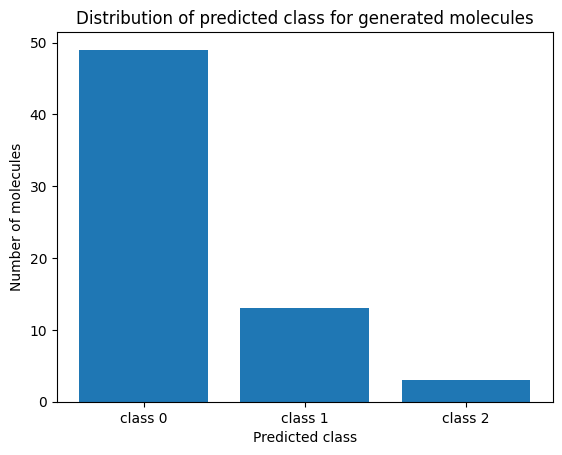

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]/content/Reinforcement-Learning-for-De-Novo-Drug-Design/models/generator_data.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
[14:48:05] SMILES Parse Error: unclosed ring for input: 'OC(CN1N=CC=C2)C1=O'
[14:48:06] SMILES Parse Error: unclosed ring for input: 'O=P(O)CC(=O)NCC1=CC=CC=C21'
[14:48:06] SMILES Parse Error: syntax error while parsing: O=C(C)C1=NC=CC(=#S1
[14:48:06] SMILES Parse Error: Failed parsing SMILES 'O=C(C)C1=NC=CC(=#S1' for input: 'O=C(C)C1=NC=CC(=#S1'
[14:48:06] SMILES Parse Error: syntax error while parsing: OC(C1=CC=CC=C2lC1=O
[14:48:06] SMILES Parse Error: Failed parsing SMILES 'OC(C1=CC=CC=C2lC1=O' for input: 'OC(C1=CC=CC=C2lC1=O'
[14:48:06] SMILES Parse Error: extra close parentheses while parsing: CC1=CC=CC=C1)C2
[1

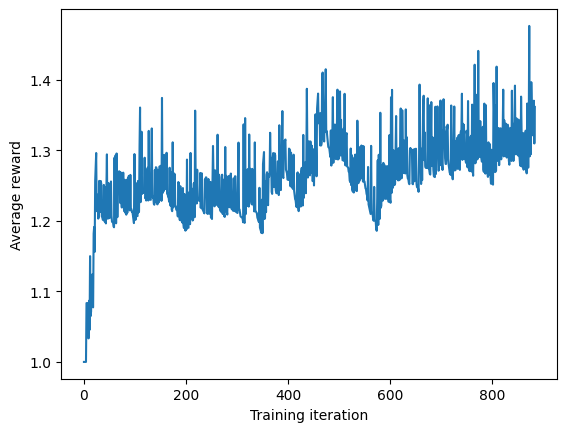

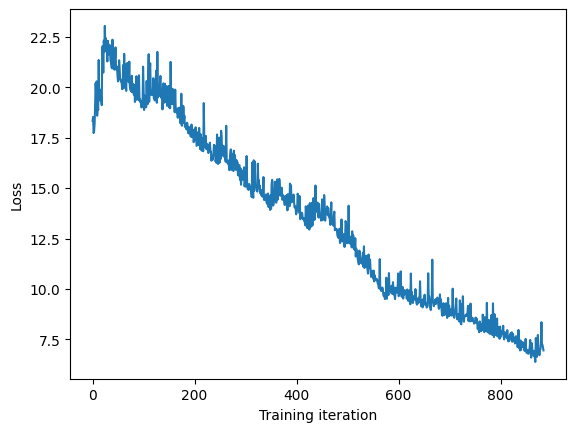

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 45.85it/s]
[14:48:22] SMILES Parse Error: unclosed ring for input: 'S=C1NN=C(CCS1)CC2=CC=CC=C4'
[14:48:22] SMILES Parse Error: extra close parentheses while parsing: OC1=CC=CC=C1)(OCC\=CC=CC=C@@C
[14:48:22] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC=C1)(OCC\=CC=CC=C@@C' for input: 'OC1=CC=CC=C1)(OCC\=CC=CC=C@@C'
[14:48:22] SMILES Parse Error: extra open parentheses for input: 'OC1=CC=CC=C1C=CCN(NC2=CC=CC=C3'
[14:48:22] SMILES Parse Error: unclosed ring for input: 'CC1=CC=CC=C11'
[14:48:22] SMILES Parse Error: extra close parentheses while parsing: O=C1CCCCCCCNS)NN=C1CC5=CC=CC=C2
[14:48:22] SMILES Parse Error: Failed parsing SMILES 'O=C1CCCCCCCNS)NN=C1CC5=CC=CC=C2' for input: 'O=C1CCCCCCCNS)NN=C1CC5=CC=CC=C2'
[14:48:22] SMILES Parse Error: unclosed ring for input: 'O=C(NCCN2C=CN=C1)=O'
[14:48:22] SMILES Parse Error: unclosed ring for input: 'CC1=CC=CC=C1CF=C(OC)C=CC=C1'
[14:48:22] SMILES Parse Error: extra close p

Percentage predict class 0 (inactive) : [0.72881356]
Percentage predict class 1 (weakly actif) : [0.27118644]
Percentage predict class 2 (strongly actif) : []
Proportion of valid SMILES: 0.295 (59/200)


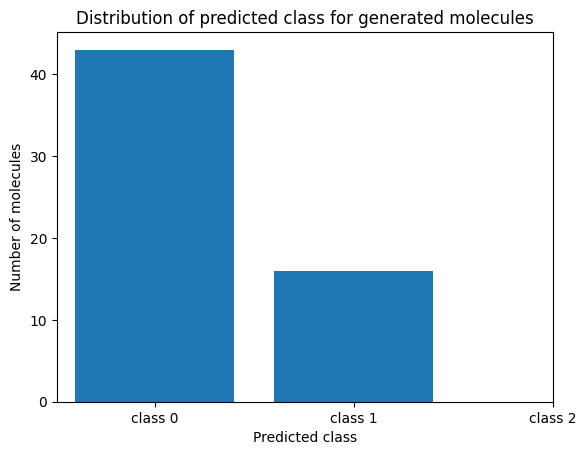

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]/content/Reinforcement-Learning-for-De-Novo-Drug-Design/models/generator_data.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
[14:48:23] SMILES Parse Error: syntax error while parsing: C[C1=CC=CC=C1
[14:48:23] SMILES Parse Error: Failed parsing SMILES 'C[C1=CC=CC=C1' for input: 'C[C1=CC=CC=C1'
[14:48:23] SMILES Parse Error: unclosed ring for input: 'S=C1NN=C(C2=CC=CC=C4)O'
[14:48:23] SMILES Parse Error: unclosed ring for input: 'OC1=C(OCCCC2=CC=CC=C2)=O'
[14:48:23] SMILES Parse Error: unclosed ring for input: 'CC(C=CC=C1)=O'
[14:48:23] SMILES Parse Error: extra close parentheses while parsing: OC(CC1=CC=CC=C1)(C=CC=C1)=O)=O
[14:48:23] SMILES Parse Error: Failed parsing SMILES 'OC(CC1=CC=CC=C1)(C=CC=C1)=O)=O' for input: 'OC(CC1=CC=CC=C1)(C=C

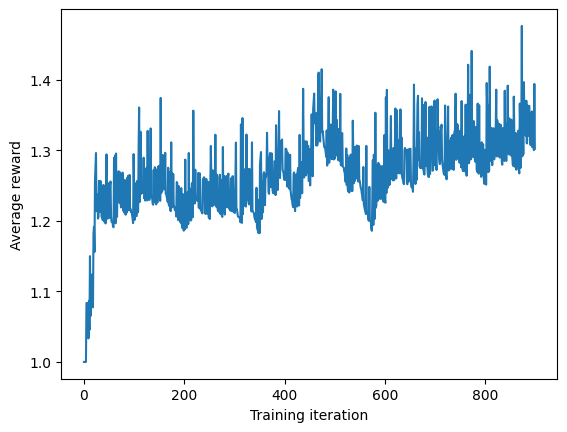

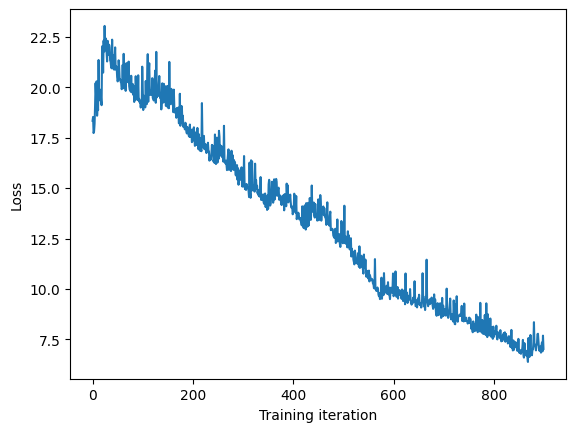

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 45.81it/s]
[14:48:39] SMILES Parse Error: extra close parentheses while parsing: CCCC(O)=O)NN1C=CC=C1
[14:48:39] SMILES Parse Error: Failed parsing SMILES 'CCCC(O)=O)NN1C=CC=C1' for input: 'CCCC(O)=O)NN1C=CC=C1'
[14:48:39] SMILES Parse Error: unclosed ring for input: 'SC(CO)=O1'
[14:48:39] SMILES Parse Error: syntax error while parsing: OC(C=C1)=[C/C1=CC=CP(O)=O
[14:48:39] SMILES Parse Error: Failed parsing SMILES 'OC(C=C1)=[C/C1=CC=CP(O)=O' for input: 'OC(C=C1)=[C/C1=CC=CP(O)=O'
[14:48:39] SMILES Parse Error: extra close parentheses while parsing: OC(C)=N1)P(OCC(C)=O)NN=C1CCC2=CC=CC=C3
[14:48:39] SMILES Parse Error: Failed parsing SMILES 'OC(C)=N1)P(OCC(C)=O)NN=C1CCC2=CC=CC=C3' for input: 'OC(C)=N1)P(OCC(C)=O)NN=C1CCC2=CC=CC=C3'
[14:48:39] SMILES Parse Error: unclosed ring for input: 'O=C1C(OCC=2NC3=CC=CC=C4)=CC=C1'
[14:48:39] SMILES Parse Error: unclosed ring for input: 'O=C(CC(OC)=O)1C4=CC=CC=C1'
[14:48:39] SMILES Parse

Percentage predict class 0 (inactive) : [0.78688525]
Percentage predict class 1 (weakly actif) : [0.19672131]
Percentage predict class 2 (strongly actif) : [0.01639344]
Proportion of valid SMILES: 0.305 (61/200)


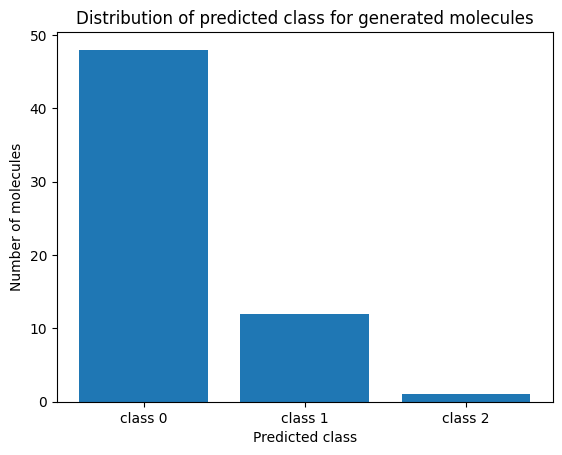

In [35]:
from models.reinforcement import Reinforcement

# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 60

RL_activity = Reinforcement(my_generator_2, my_predictor, get_reward_activity)

rewards = []
rl_losses = []

for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_activity.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward))
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))

    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()

    smiles_cur, prediction_cur = estimate_and_update(RL_activity.generator,
                                                     my_predictor,
                                                     n_to_generate)

Generating molecules...:   0%|          | 0/10000 [00:00<?, ?it/s]/content/Reinforcement-Learning-for-De-Novo-Drug-Design/models/generator_data.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
Generating molecules...: 100%|██████████| 10000/10000 [03:27<00:00, 48.10it/s]
[14:55:50] SMILES Parse Error: extra open parentheses for input: 'OC1=OCC(NC=CC=1'
[14:55:50] SMILES Parse Error: extra close parentheses while parsing: OC1=CC=CC=C1)N=N1
[14:55:50] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC=C1)N=N1' for input: 'OC1=CC=CC=C1)N=N1'
[14:55:50] SMILES Parse Error: unclosed ring for input: 'SC(C1=CC=CC=C11)=O'
[14:55:50] SMILES Parse Error: unclosed ring for input: 'O=C1C2=CC=CC=C2'
[14:55:50] SMILES Parse Error: unclosed ring for input: 'S=C(N1)CC2=CC=CC=C1'
[14:55:50] SMILES Parse Error: ex

Percentage predict class 0 (inactive) : [0.76352288]
Percentage predict class 1 (weakly actif) : [0.19694868]
Percentage predict class 2 (strongly actif) : [0.03952843]
Proportion of valid SMILES: 0.1442 (1442/10000)


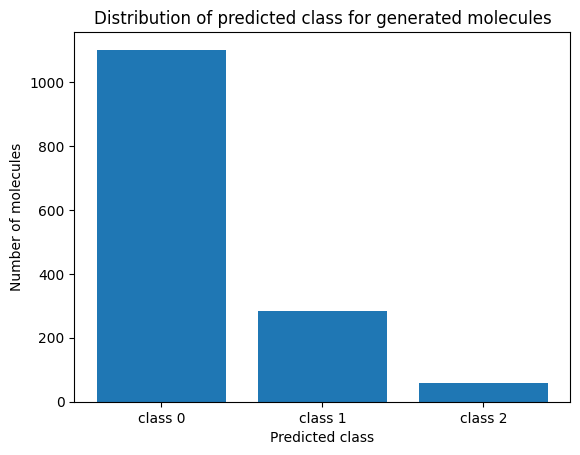

In [36]:
smiles_biased, prediction_biased = estimate_and_update(RL_activity.generator,
                                                       my_predictor,
                                                       n_to_generate=10000)

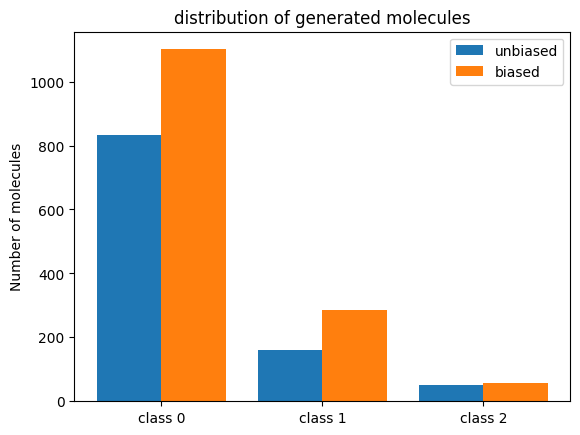

In [39]:
class_val = [0, 1, 2]

value1, count1 = np.unique(prediction_unbiased, return_counts=True)
value2, count2 = np.unique(prediction_biased, return_counts=True)

if len(value1) != len(class_val):
    tmp = []
    for c in class_val:
        if c not in value1:
            tmp.append(count1[np.where(value1==c)])
        else:
            tmp.append(0)
    count1 = tmp
if len(value2) != len(class_val):
    tmp = []
    for c in class_val:
        if c not in value2:
            tmp.append(count2[np.where(value2==c)])
        else:
            tmp.append(0)
    count2 = tmp

w, x = 0.4, np.arange(len(class_val))

fig, ax = plt.subplots()
ax.bar(x - w/2, count1, width=w, label='unbiased')
ax.bar(x + w/2, count2, width=w, label='biased')

ax.set_xticks(x)
ax.set_xticklabels(['class 0', 'class 1', 'class 2'])
ax.set_ylabel('Number of molecules')
ax.set_title('distribution of generated molecules')
ax.legend()

plt.show()